DATA620 Project 2
Ivan Tikhonov

1.Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2.Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3.What can you infer about each of the distinct groups?

Choosing the Data
I have decide to build on the flight data from OpenFlights.org https://openflights.org/data.html

OpenFlights consists of the following datasets:

Airports
Airlines
Routes
Planes
Schedules
I have choosen to use the Routes and Airports datasets to build our network. I will use Airline ID and Source Airport ID from the Routes dataset as our two nodes. Each route record will be an edge between the two ntypes of nodes and we will add weighting by the number of routes that each airine has leaving from each particular airport. I will get additional airport node attribute data from the Airports dataset.

Variables used from the Routes dataset:

Airline ID - Unique OpenFlights identifier for airline (see Airline).
Source airport ID - Unique OpenFlights identifier for source airport (see Airport)
Variables used from the Airports dataset:

Name
City
Country
IATA
Latitude
Longtitude
Data is saved as .DAT files. They are UTF-8 encoded.

Loading the Data
First import necessary packages for plotting graphs using NetworkX and Matplotlib and set up graph size parameters...

In [2]:
import networkx as nx
from networkx.algorithms import bipartite as bi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
routes_raw = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat", 
                       header=None, sep=",", 
                       usecols=[0, 2], 
                       names=['Airline', 'Airport'])

routes_raw=routes_raw.dropna()

In [4]:
routes_raw.head(15)

Airline Airport
0       2B     AER
1       2B     ASF
2       2B     ASF
3       2B     CEK
4       2B     CEK
5       2B     DME
6       2B     DME
7       2B     DME
8       2B     DME
9       2B     EGO
10      2B     EGO
11      2B     GYD
12      2B     KGD
13      2B     KZN
14      2B     KZN

Add Weights to the Dataframe
I chose to count the number of routes for each eirline at each airport and use that as a weight for our airline to airport edges.

In [5]:
aa = routes_raw.copy()

In [6]:
aa['weight'] = aa.groupby('Airline')['Airport'].transform('count')

In [7]:
aa.head(10)

Airline Airport  weight
0      2B     AER      42
1      2B     ASF      42
2      2B     ASF      42
3      2B     CEK      42
4      2B     CEK      42
5      2B     DME      42
6      2B     DME      42
7      2B     DME      42
8      2B     DME      42
9      2B     EGO      42

In [8]:
len(aa)

67663

Get Additional Airport Data

In [10]:
airports_raw = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", 
                       header=None, sep=",", 
                       usecols=[1, 2, 3, 4, 6, 7], 
                       names=['Airport Name','City','Country','IATA', 'Latitude', 'Longitude'])
#airports_raw1=airports_raw[airports_raw.Country=='France']

In [11]:
airports_raw.head()

Airport Name          City  \
0                               Goroka Airport        Goroka   
1                               Madang Airport        Madang   
2                 Mount Hagen Kagamuga Airport   Mount Hagen   
3                               Nadzab Airport        Nadzab   
4  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  Latitude   Longitude  
0  Papua New Guinea  GKA -6.081690  145.391998  
1  Papua New Guinea  MAG -5.207080  145.789001  
2  Papua New Guinea  HGU -5.826790  144.296005  
3  Papua New Guinea  LAE -6.569803  146.725977  
4  Papua New Guinea  POM -9.443380  147.220001

In [12]:
len(airports_raw)

7698

In [13]:
aa_merged = airports_raw.copy()

In [14]:
aa_merged = pd.merge(aa,aa_merged,left_on='Airport',right_on='IATA',how='inner')

In [15]:
aa_merged.head()

Airline Airport  weight                 Airport Name   City Country IATA  \
0      2B     AER      42  Sochi International Airport  Sochi  Russia  AER   
1      7J     AER      34  Sochi International Airport  Sochi  Russia  AER   
2      9U     AER      38  Sochi International Airport  Sochi  Russia  AER   
3      B2     AER      82  Sochi International Airport  Sochi  Russia  AER   
4      HY     AER     151  Sochi International Airport  Sochi  Russia  AER   

    Latitude  Longitude  
0  43.449902    39.9566  
1  43.449902    39.9566  
2  43.449902    39.9566  
3  43.449902    39.9566  
4  43.449902    39.9566

In [17]:
airport_nodes = aa_merged[['Airport','Airport Name','City','Country','IATA','Latitude','Longitude']].drop_duplicates().sort_values(by='Airport')


Check for Airline Codes that Match Airport Codes

In [18]:
set(aa_merged['Airline']) & set(aa_merged['Airport']) 

{'ABJ', 'IOS'}

There are two three letter codes that are used for both airlines and airports, so I have to add differentiation to the names before adding these airport atributes to the graph or all our airlines will also get coded as airports... To keep things short and so I can still read out graph once it's plotted, I added just an L for airLines just to those two airline codes.

In [19]:
#aa_merged['Airline'] = 'L_' + aa_merged.Airline.map(str)
#aa_merged['Airport'] = 'P_' + aa_merged.Airport.map(str)
#airport_nodes['Airport'] = 'P_' + airport_nodes.Airport.map(str)

aa_merged['Airline'] = np.where(
    aa_merged['Airline'].isin(['ABJ', 'IOS']),
    'L_' + aa_merged.Airline.map(str),
    aa_merged.Airline
)

In [20]:
set(aa_merged['Airline']) & set(aa_merged['Airport']) 

set()

In [21]:
aa_merged.head()

Airline Airport  weight                 Airport Name   City Country IATA  \
0      2B     AER      42  Sochi International Airport  Sochi  Russia  AER   
1      7J     AER      34  Sochi International Airport  Sochi  Russia  AER   
2      9U     AER      38  Sochi International Airport  Sochi  Russia  AER   
3      B2     AER      82  Sochi International Airport  Sochi  Russia  AER   
4      HY     AER     151  Sochi International Airport  Sochi  Russia  AER   

    Latitude  Longitude  
0  43.449902    39.9566  
1  43.449902    39.9566  
2  43.449902    39.9566  
3  43.449902    39.9566  
4  43.449902    39.9566

Create NetworkX Graph Object
First we will create a full bipartite network with both nodes.

In [22]:
B = nx.Graph()
B.add_nodes_from(aa_merged['Airline'], bipartite=0)
B.add_nodes_from(aa_merged['Airport'], bipartite=1)
B.add_weighted_edges_from([tuple(d) for d in aa_merged[['Airline','Airport','weight']].values])

nx.set_node_attributes(B, airport_nodes.set_index('Airport').to_dict('index'))

Let's double check if our attributes were saved in the graph data.

In [23]:
list(B.nodes(data=True))[:3]

[('2B', {'bipartite': 0}), ('7J', {'bipartite': 0}), ('9U', {'bipartite': 0})]

In [24]:
list(B.nodes(data=True))[-2:]

[('WIN',
  {'bipartite': 1,
   'Airport Name': 'Winton Airport',
   'City': 'Winton',
   'Country': 'Australia',
   'IATA': 'WIN',
   'Latitude': -22.36359977722168,
   'Longitude': 143.08599853515625}),
 ('WYA',
  {'bipartite': 1,
   'Airport Name': 'Whyalla Airport',
   'City': 'Whyalla',
   'Country': 'Australia',
   'IATA': 'WYA',
   'Latitude': -33.05889892578125,
   'Longitude': 137.51400756835938})]

In [45]:
B.get_edge_data('L_AER','P_KZN')

Set 'Top' and 'Bottom' Nodes

In [46]:
airline_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
airport_nodes = set(B) - airline_nodes

Check if the Graph is Connected

In [47]:
nx.is_connected(B)

False

Check if the Graph is Bipartite

In [48]:
bi.is_bipartite(B)

True

Density

In [49]:
print(bi.density(B, airline_nodes))

0.010335248855134054


In [50]:
print(bi.density(B, airport_nodes))

0.010335248855134054


Use Island Method on the Bipartite Graph
The functions below will use the edge weights to trim the graph into subgraphs at different minimum weight levels. Any node not connected by at least one ede with the minimum weight will be cut from the graph. 

In [55]:
def trim_edges(g, weight=1): 
    g2=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            g2.add_edge(f,to,attr_dict={weight:edata['weight']})
    g2.add_nodes_from(my_list, bipartite=0)
    g2.add_nodes_from(my_list1, bipartite=1)
    return g2

def island_method(g, iterations=5, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations-1))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

Run island_method function using 4 iterations and a minimum weight 'water line' of 350...

In [57]:
nx.__version__

'2.8.4'

In [59]:
islands = island_method(B, 4, 350)
print('min weight - ', '# of nodes - ', '# of island subgraphs')
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], '     -     ', len(i[1]), '     -     ', len(list(nx.connected_components(i[1]))))

min weight -  # of nodes -  # of island subgraphs
350      -      1733      -      1
1061      -      1060      -      1
1772      -      776      -      1
2483      -      177      -      1


In [38]:
islands[1][0] # the first index refers to the threshold

1061

In [39]:
islands[1][1] # the second index refers to the graph object

Graph the Largest 'Island' Subgraph - minimum weight level 350

In [40]:
def set_colors(G):
    colors = []
    for node, data in G.nodes(data=True):
        if data['bipartite'] == 1: 
            colors.append('olivedrab') # Airports in Green    
        else:
            colors.append('cornflowerblue')  # Airlines in Blue
    return colors

In [76]:
G0=islands[0][1]

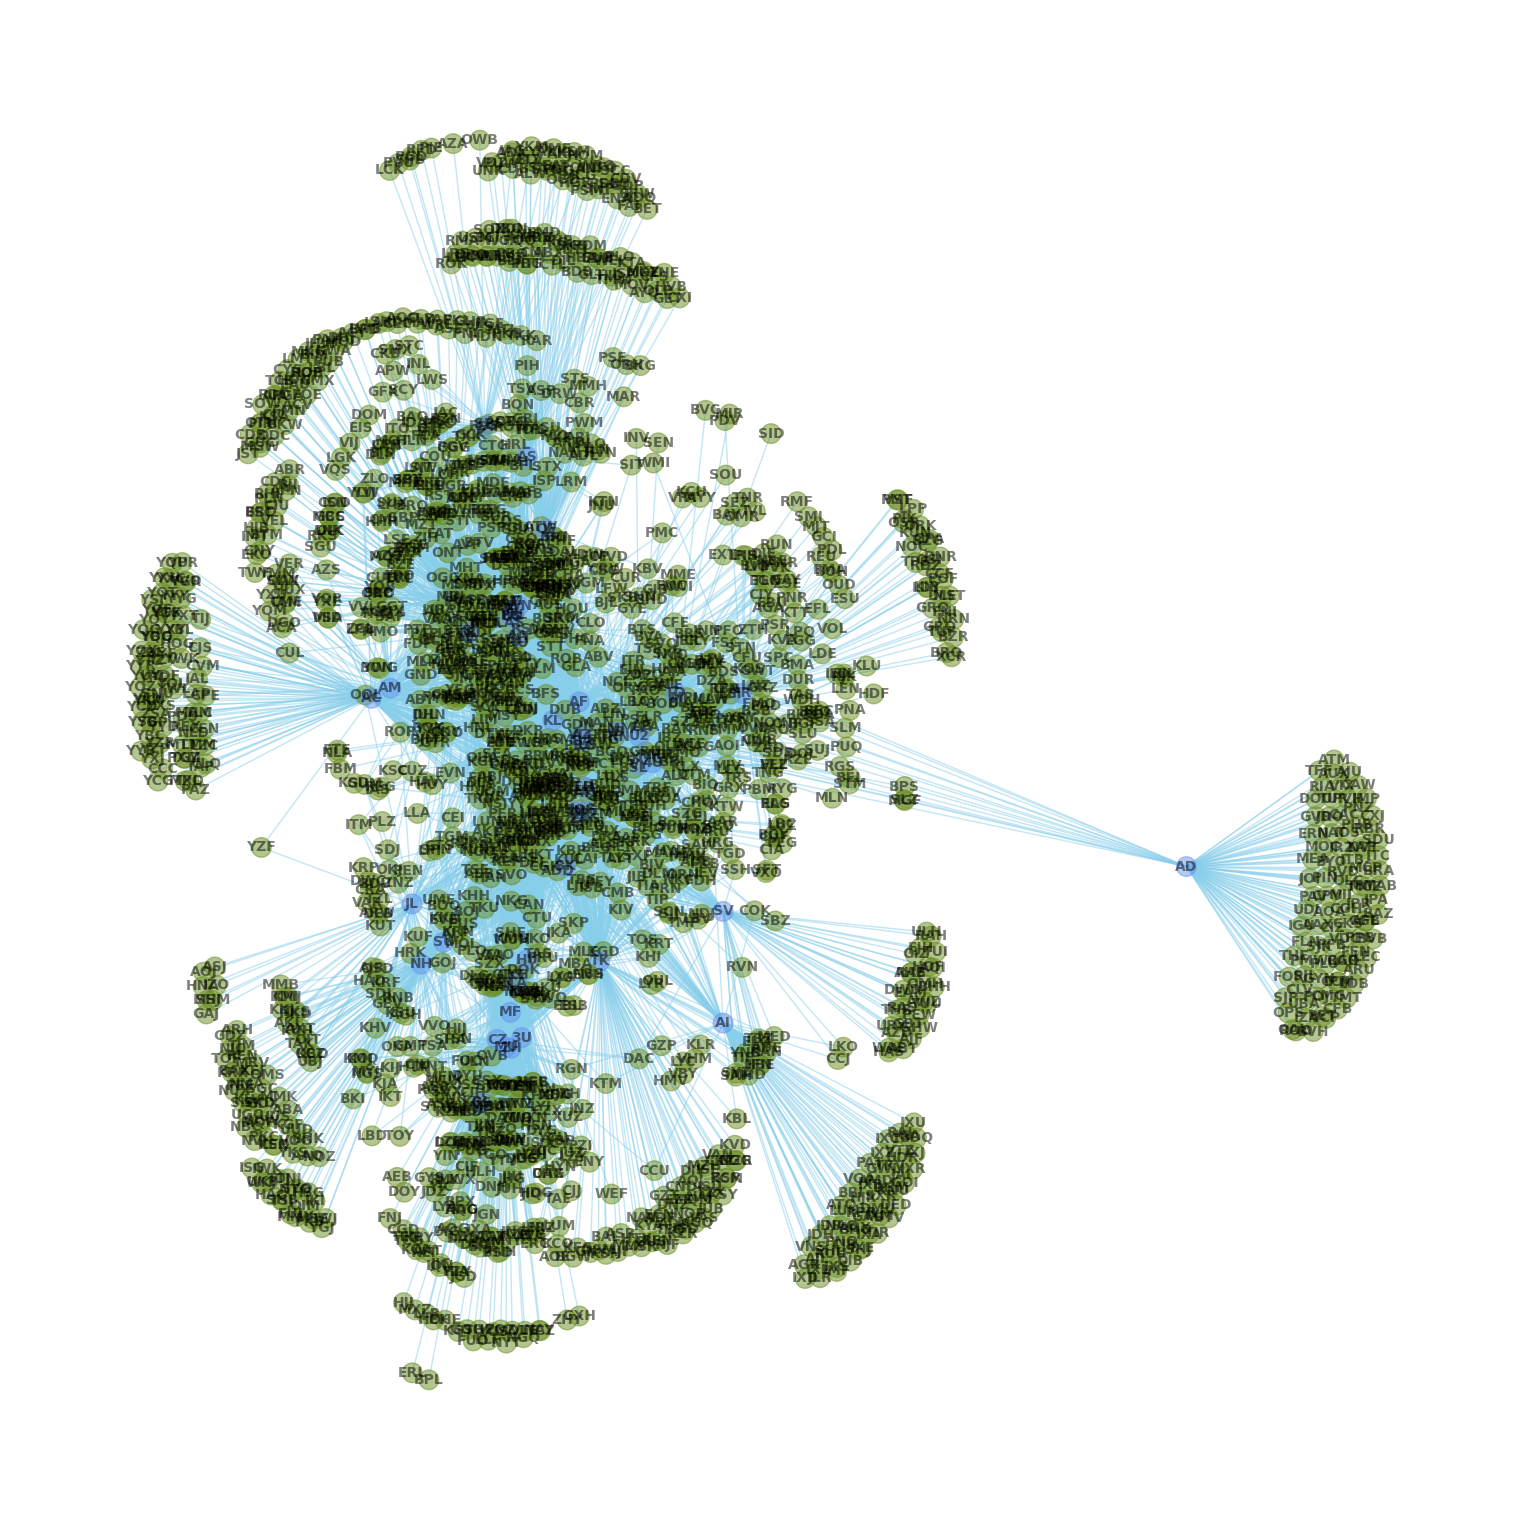

In [77]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G0)  # set colors
#weights = [math.log(edata['attr_dict'][200]) for f, t, edata in G0.edges(data=True)] # set weights

nx.draw(G0, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

Graph the Second Largest 'Island' Subgraph - minimum weight level 1061

In [64]:
G1=islands[1][1]

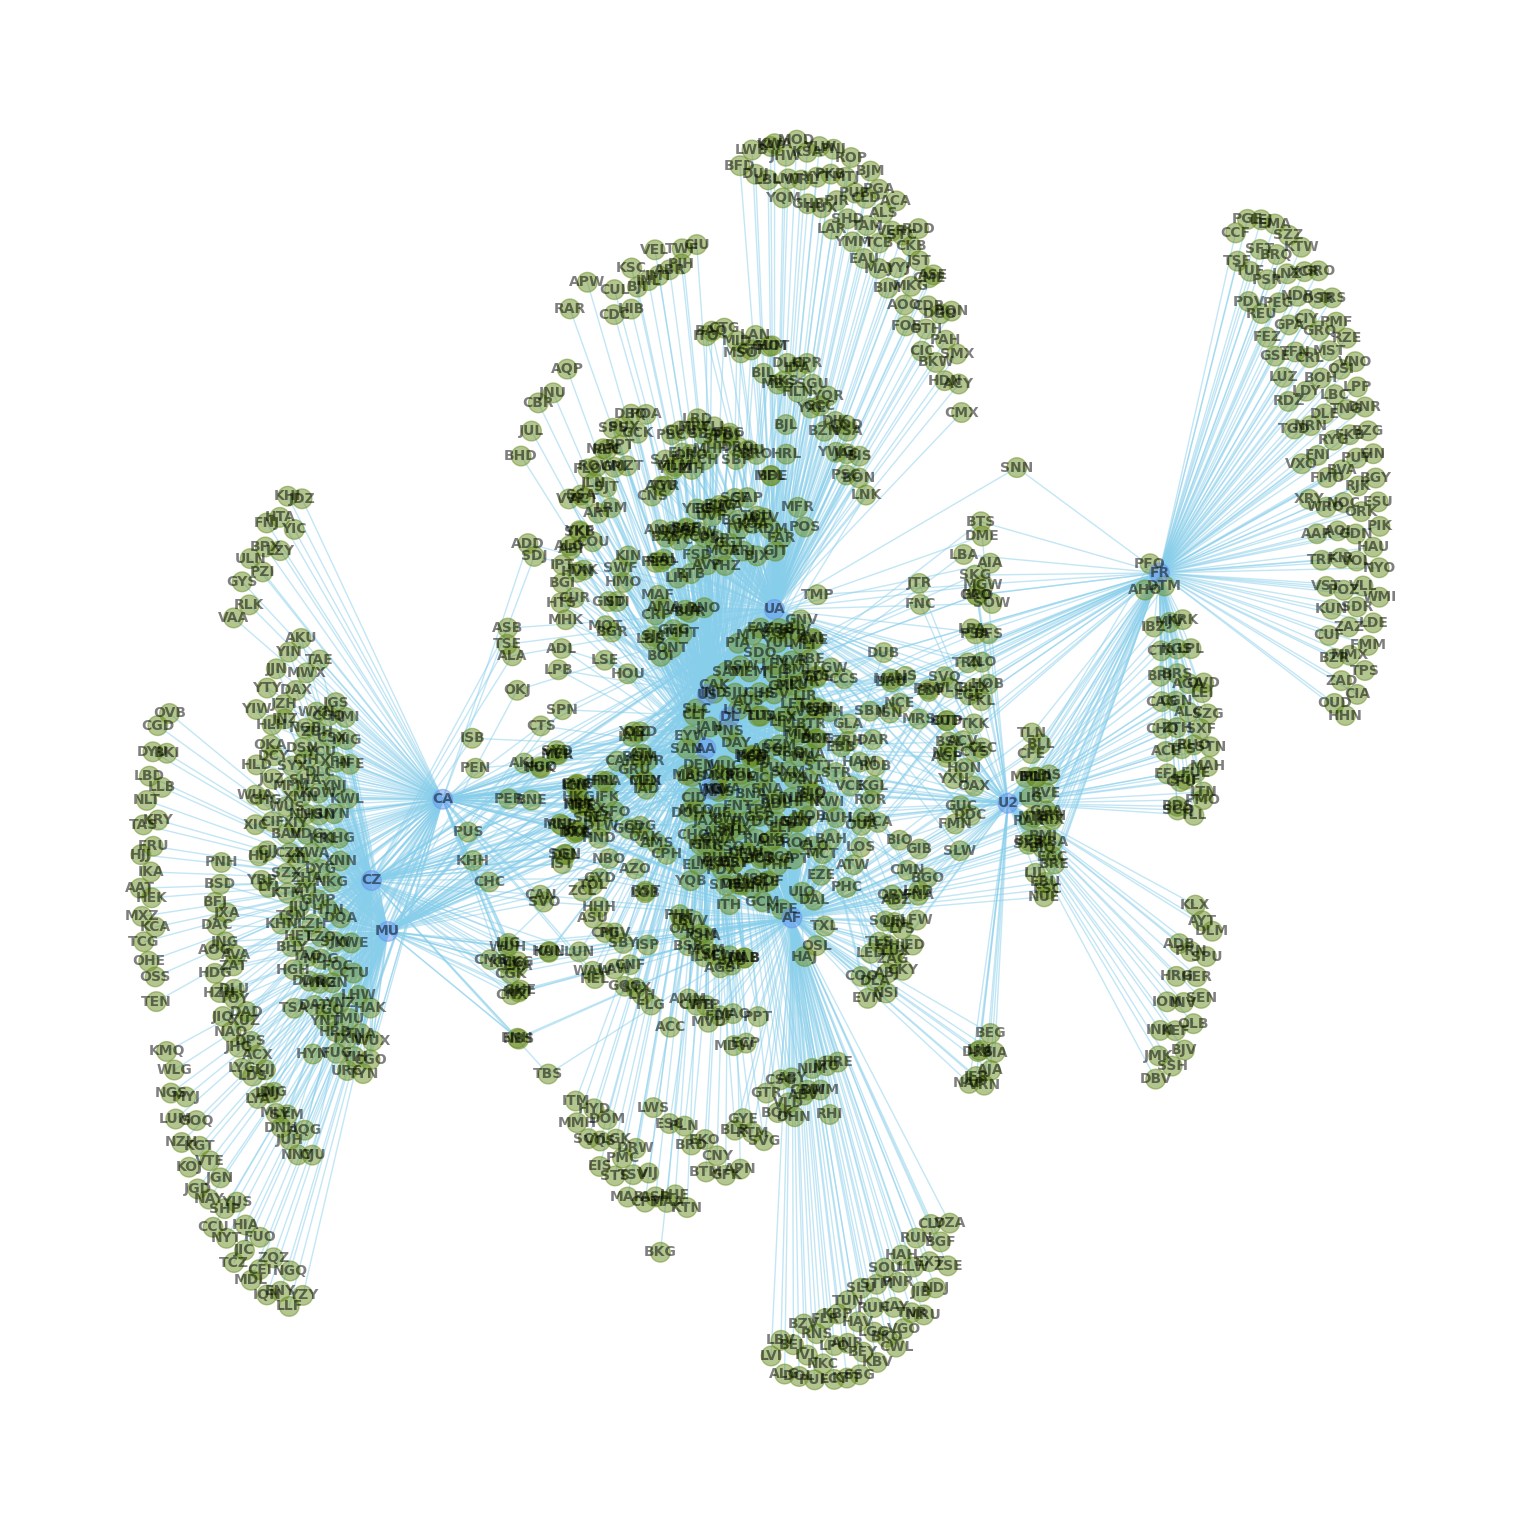

In [65]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G1)  # set colors

nx.draw(G1, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

Major airlines are starting to be visible with the airports that they connect. Many cliques are startig to develop and airlines are starting to show as boundary spanners. A higher water level may make it easier to pick out individual airlines and airports.

Graph the Third Largest 'Island' Subgraph - minimum weight level 1772

In [66]:
G2=islands[2][1]

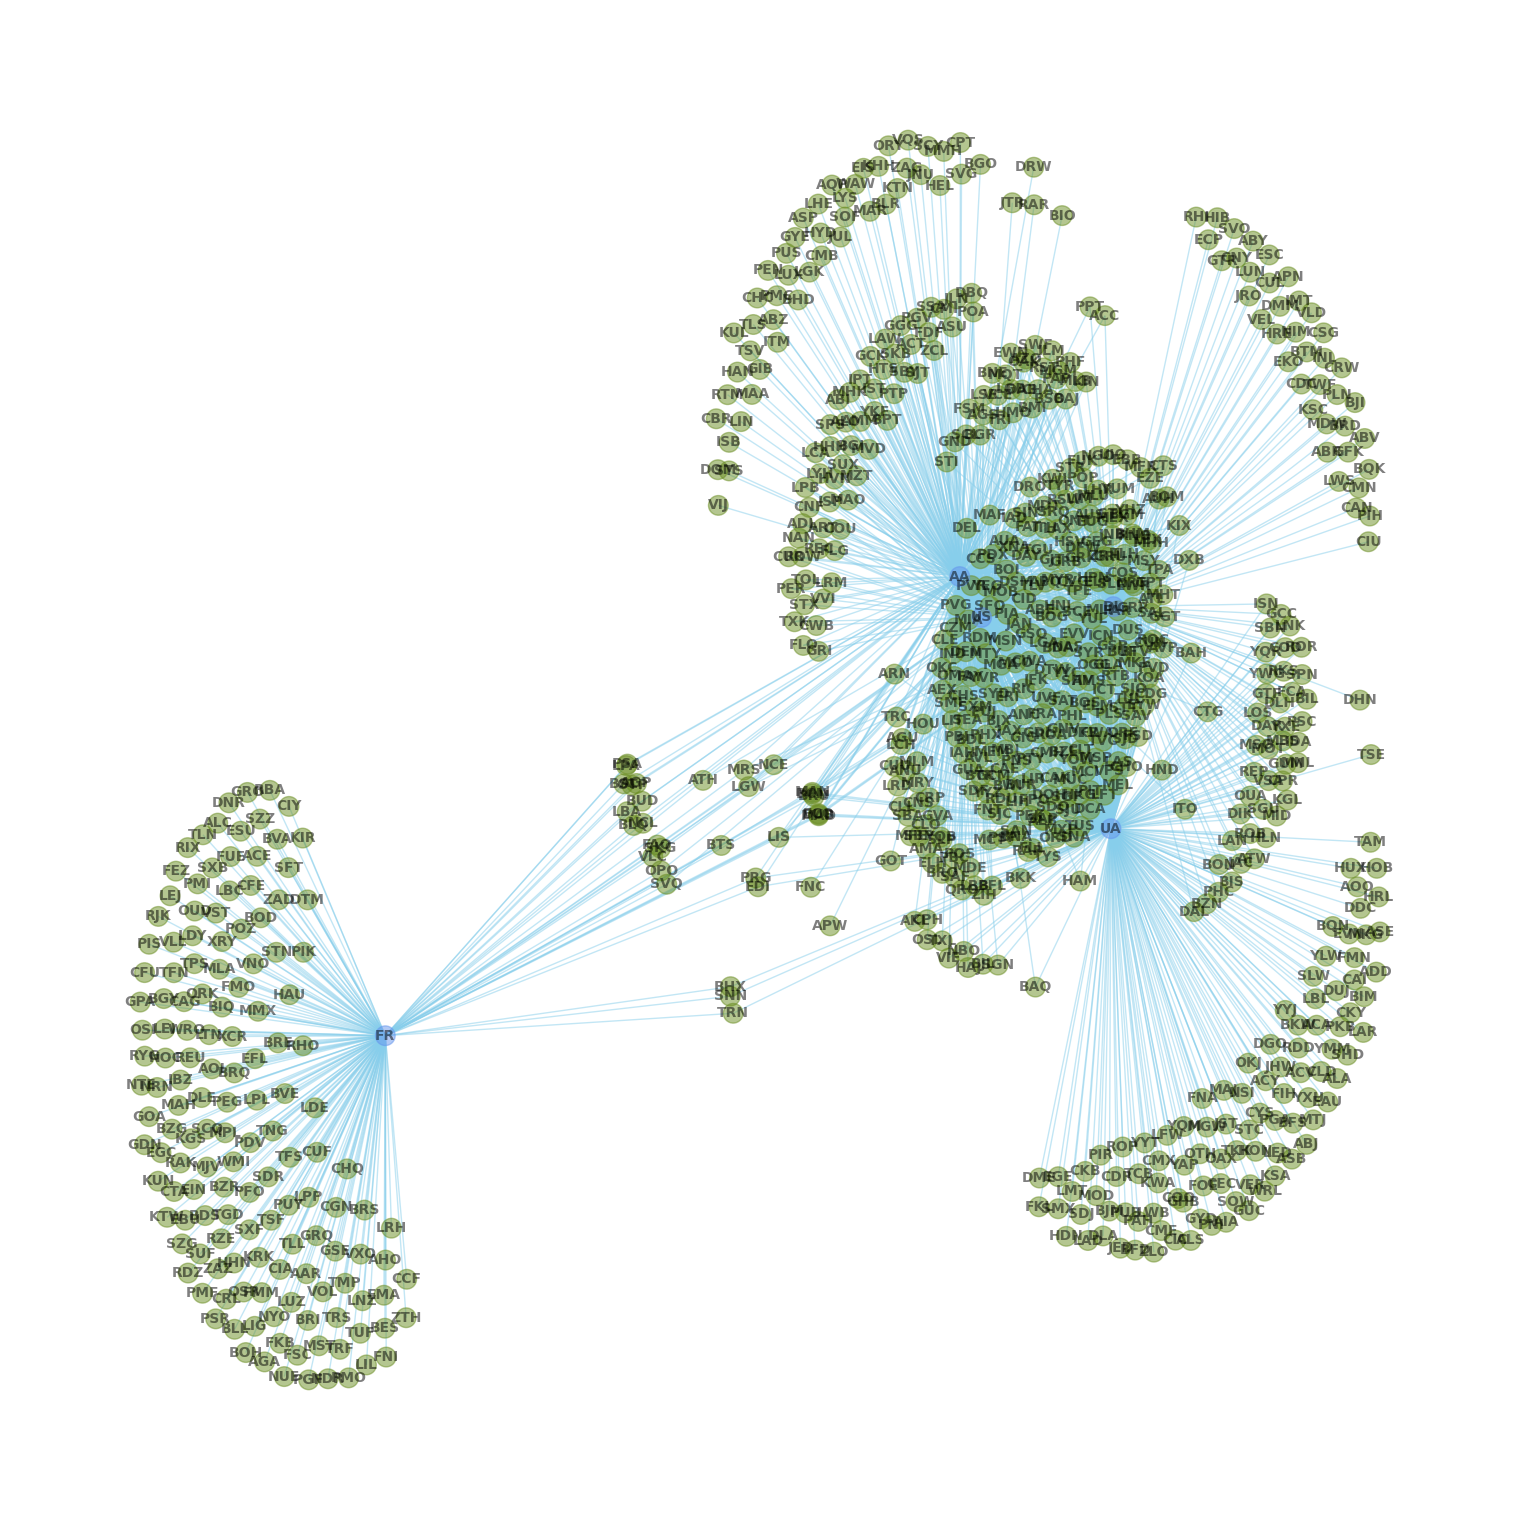

In [67]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G2)  # set colors

nx.draw(G2, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

Here we can really start to see the 4 most influential airlines in the network:

FR - Air France
UA - United Airlines
DL - Delta Air Lines
US - US Airways
AA - American Airlines
If there are any others they are still hidden in the graph. Air France clearly stands out as a boundary spanner in this graph.

Graph the Fourth Largest 'Island' Subgraph - minimum weight level 2483

In [68]:
G3=islands[3][1]

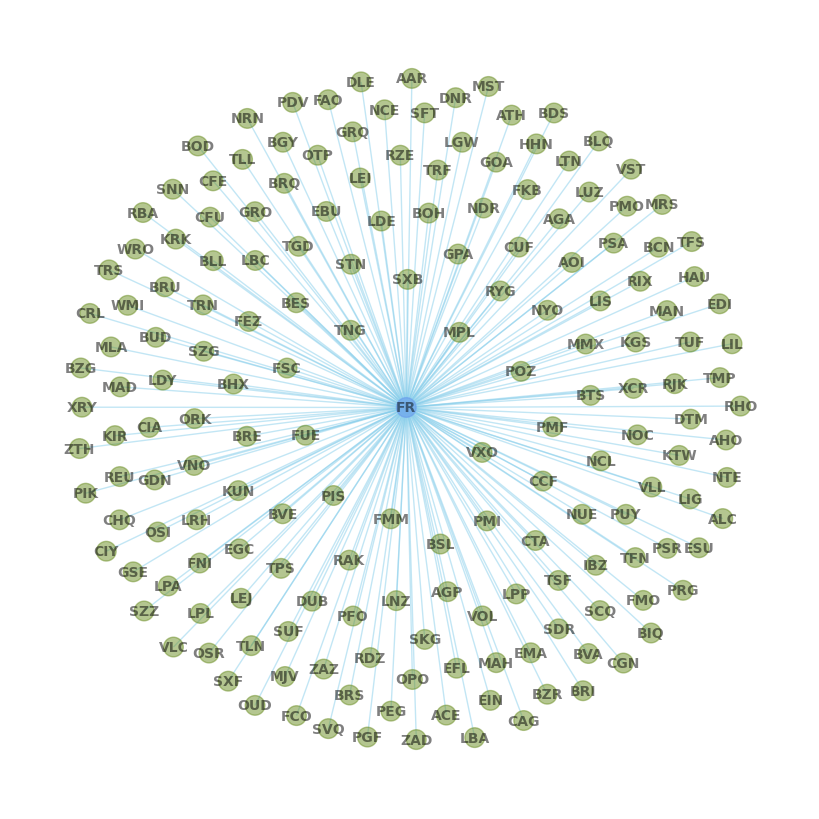

In [69]:
plt.rcParams["figure.figsize"] = (8,8) # set plot size
colors = set_colors(G3)  # set colors

nx.draw(G3, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)

In this last graph we can see that FR, Air France, is the most influential airline in the network.



References


https://en.wikipedia.org/wiki/List_of_airports_by_IATA_code:_A

https://airportcod.es/